# Still missing stuff:
* Chris Mathy's favorite performance metric is not used
* Include validation data set
* If performance decreases drastically when using cellular automata, then we may want to try and use is to enrich the information already available. E.g. instead of using the original 28x28 pixels image, we may use 28x28x2 (where the extra dimension includes the image after image classification). This would most likely not decrease performance, but perhaps increase it.
* *Please add other things on this "to do list" that are missing*

# Loading packages

In [1]:
from functions import *
import cv2, keras
import numpy as np
import pandas as pd
from keras import layers
from keras.utils import np_utils
from keras.datasets import mnist
from scipy.signal import medfilt
from sklearn.preprocessing import normalize
from sklearn import svm, metrics, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing

## Load MNIST

In [2]:
# Load data
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Concatenate to a single dataset so that we may add validation set also
X = np.concatenate((train_X, test_X), axis=0)
y = np.concatenate((train_y, test_y), axis=0)

# Subset for faster processing
X = X[:250]
y = y[:250]

## Game of Life

In [3]:
# Binarize (X, not y). Include all pixels with some any value that's not 0
X_bina = np.array([make_binary(np.array(img.copy(), dtype=np.int32), 1) for img in X])

# Perform Game of Life
X_GoL = np.array([GoL(img, 3) for img in X_bina])

# Only get the last iteration output
X_GoL_last_iter = X_GoL[:, -1,: ,:]

# Get a timeseries with number of active pixels for each iteration (note that the seed is also included here)
X_GoL_timeseries = []

for i in range(X_GoL.shape[0]):
    sum_of_array = []
    for k in range(X_GoL.shape[1]):
        sum_of_array.append(sum(X_GoL[i, k, :, :].flatten()[X_GoL[i, k, :, :].flatten() == 255])//255)
    X_GoL_timeseries.append(sum_of_array)

X_GoL_timeseries = np.array(X_GoL_timeseries)

## Corrosion

### Retrieve mean number of active cells for each class

In [4]:
X_find, _, y_find, _ = train_test_split(X, y, test_size = .10, random_state=42)

# Retrieve indices for all samples of zeros, ones, two's, etc. ...
indices = []
for i in range(10):
    indices.append(list(np.where(y_find==i)[0]))

# List of average active cells for each number
mean_cells_active = []

# For each number in range 0, 1, 2, .. 9.
for number in range(len(indices)):
    active_cells_in_images = []

    # For each list of image indices
    for index in indices[number]:
        active_cells_in_img = len(X_find[index][X_find[index] > 0])
        active_cells_in_images.append(active_cells_in_img)
    
    mean_cells_active.append(np.mean(active_cells_in_images))

### Perform corrosion and retrieve corrosion measure for each generation

In [5]:
# For each element in the feature set X, calculate the increase in corrosion.
corrosion_increase_by_number = np.array(corrosion_increase(X, y, 8, 6, 0.1, Q, mean_cells_active))

# Output has dim(1000 x n_generations) The elements are the increase in corrosion (using the measure Jakob came up with)

c:\Users\Lenovo\Desktop\Data science\scripts\functions.py:129: RuntimeWarning: overflow encountered in ubyte_scalars
  d = seed[r+1, c+1] - np.min(context)


# Machine learning

## Prepare data for ML function

In [6]:
# Min-max scaling
# X = X/255.0
# X_bina = X_bina/255.0
# X_GoL = X_GoL/255.0

# Prepare lists for loop
feature_sets = [X, X_bina, X_GoL_last_iter] # Add the other image processing types to this list
feature_set_names = ["X", "X_bina", "X_GoL_last_iter"] # Add the other image processing types to this list

## Perform ML

In [26]:
%%capture

# Perform ML on the list of feature sets
performances = ML(feature_sets, feature_set_names, y)[0]

In [35]:
performances["X"]["lr"][0]

array([2.31054755e-06, 1.01551556e-08, 1.29944504e-05, 1.72220752e-05,
       9.16368412e-01, 1.10971112e-03, 1.86111825e-02, 2.52733069e-02,
       3.67461644e-03, 3.49302340e-02])

## Inspect performance

In [11]:
# Inspect example of performance
#performance["X_GoL"]["lr"]["classification_report"]

,0,1,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.500000,0.625000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.28,0.162037,0.298333
recall,0.333333,0.555556,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.28,0.209877,0.280000
f1-score,0.400000,0.588235,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.28,0.165359,0.279765
support,3.000000,9.000000,1.0,4.0,1.000000,0.0,1.0,3.0,3.0,0.28,25.000000,25.000000


# Plots for exam paper

## MNIST example
* Example of the dataset

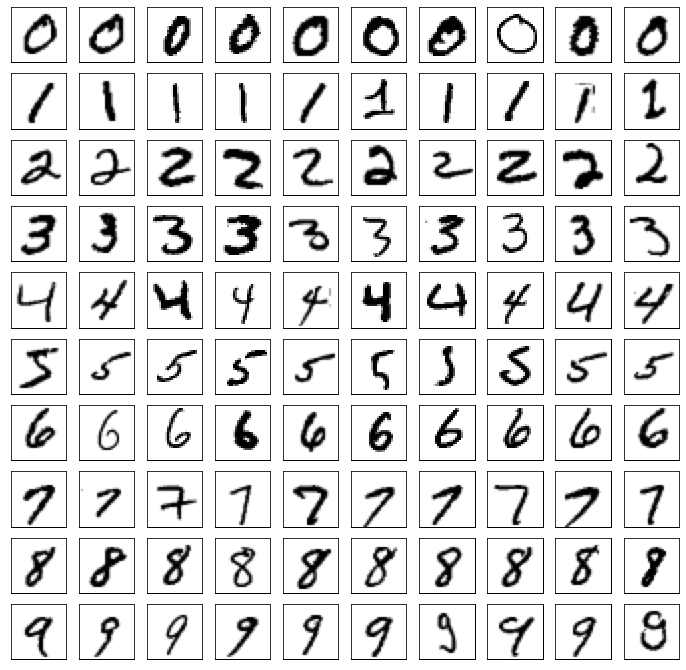

In [12]:
# Retrieve indices for 10 samples of zeros, ones, two's, etc. ...
indices = []
for i in range(10):
    indices.append(list(np.where(y==i)[0][0:10]))

# Flatten list of indices
indices = [item for sublist in indices for item in sublist]

# Plot images with indices and save
_, axs = plt.subplots(10, 10, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(X[indices], axs):
    ax.imshow(img, cmap="gray_r") # Plot image
    ax.axes.xaxis.set_ticklabels([]) # Remove ticklabels for both axes
    ax.axes.yaxis.set_ticklabels([])
    ax.set_xticks([]) # Remove ticks (minor and major) from both axes
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    ax.patch.set_edgecolor('black') # Border around each subplot
    ax.patch.set_linewidth('1')
plt.savefig(os.path.join('output', 'mnist_example.png'))
plt.show()

## Seed image over generations
* Showing how images evolve for:
  * Game of Life
  * Corrosion

### Game of Life

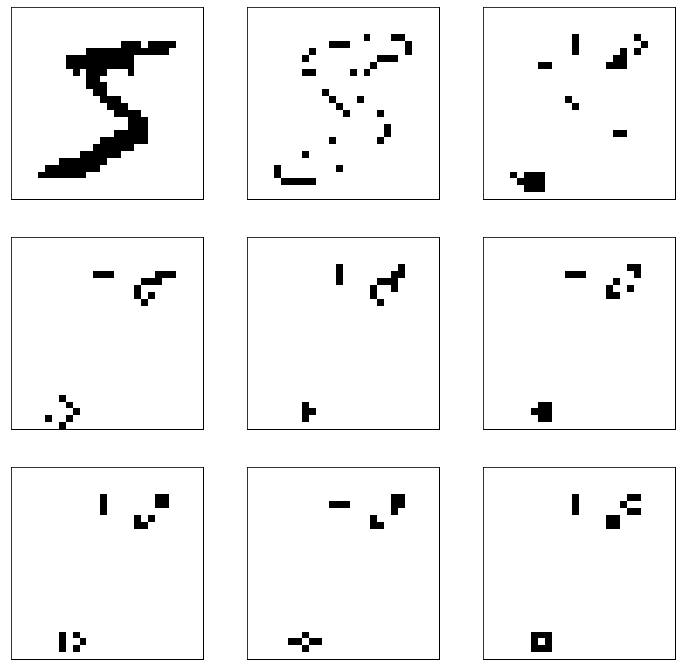

In [13]:
# Binarize an image and make GoL generations
img = make_binary(np.array(train_X[0], dtype=np.int32), 125)
generations = GoL(img, 8)

# Plot generations and save
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(generations, axs):
    ax.imshow(img, cmap="gray_r")
    ax.axes.xaxis.set_ticklabels([]) # Remove ticklabels for both axes
    ax.axes.yaxis.set_ticklabels([])
    ax.set_xticks([]) # Remove ticks (minor and major) from both axes
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    ax.patch.set_edgecolor('black') # Border around each subplot
    ax.patch.set_linewidth('1')
plt.savefig(os.path.join('output', 'generations_example.png'), transparent = True)
plt.show()

### Corrosion

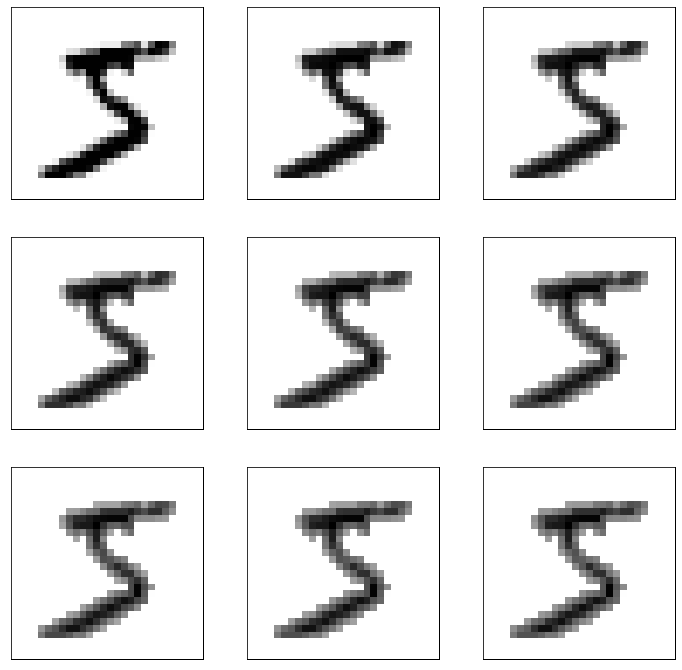

In [14]:
# Binarize an image and make GoL generations
img = train_X[0]

# Define q(d, l) - Function that calculates impending corrosion speed - also based on y.
def Q(d, l):
    return (255 - d) * l

# Do corrosion, 8 steps
generations = corrosion(img, 8, 0.1, 3, Q)

# Plot corrosion
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(generations, axs):
    ax.imshow(img, cmap="gray_r")
    ax.axes.xaxis.set_ticklabels([]) # Remove ticklabels for both axes
    ax.axes.yaxis.set_ticklabels([])
    ax.set_xticks([]) # Remove ticks (minor and major) from both axes
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    ax.patch.set_edgecolor('black') # Border around each subplot
    ax.patch.set_linewidth('1')
plt.savefig(os.path.join('output', 'generations_example.png'), transparent = True)
plt.show()

## Testing sobel

(Text(0.5, 1.0, 'Sobel Y'), ([], []), ([], []))

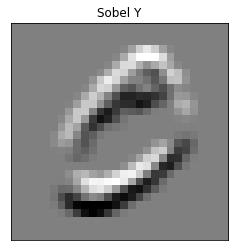

In [5]:
img = X[1]

sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)

plt.subplot(1,1,1),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
